# [Run 1.2i] Using the LSST Stack tools to do positional matching on coadd and src catalogs
<br>Owner: **Ji Won Park** ([@jiwoncpark](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@jiwoncpark)) modified a similar notebook for Run 1.1p written by **Jim Chiang** ([@jchiang87](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@jchiang87)).
<br>Last Run: **2019-02-27**

**Note:** 
- This notebook reflects some schema changes that went into effect from Run 1.2i and, correspondingly, Generation 2 of Butler. If you're interested in Run 1.1p, go to Jim's original notebook [here](https://nbviewer.jupyter.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_stack.nbconvert.ipynb) instead.
- I also added some more annotations to guide DM beginners like me! They were mostly taken from function docstrings in [daf-persistence source code](https://github.com/lsst/daf_persistence) and [lsst skymap source code](https://github.com/lsst/skymap).

In this notebook, we use the data butler to retrieve catalogs from coadd and visit-level analyses of Run 1.2i, and use the `lsst.afw.table.matchRaDec` function to do positional matching against galaxy truth info extracted from the protoDC2 extragalactic catalog v3.0, on which Run 1.2i was based. To enable this, we show how to create a `SourceCatalog` object from the galaxy truth info provided by the GCR interface.

## Set Up

In [1]:
import warnings
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.geom as afw_geom
import lsst.afw.table as afw_table
import lsst.daf.persistence as dp
import GCRCatalogs

Normally, the following code to rotate the protoDC2 field to the Run 1.2i field would be imported from the `LSSTDESC/sims_GCRCatSimInterface` package, but we include it here so that the `desc-stack` kernel can be used without modifying it to include the various DESC packages used with Run 1.2i.

In [2]:
# to allow local import when using desc-stack kernel
import sys
sys.path.insert(0, '')

from utils.fieldRotator import FieldRotator

## How To Create a Source Catalog

In order to use the Stack's spatial matching code, we will need to reformat the extragalactic catalog galaxy position and magnitude information into an afw `SourceCatalog` object. These table objects are initialized by a "schema", which in turn is built from column definition "Coldef" objects.  The `mag_cols` function below shows how these Coldefs can be created.

In [3]:
def make_SourceCatalog(new_cols):
    """
    Make a SourceCatalog to contain id and coordinates for each object, plus any new
    columns.
    
    Parameters
    ----------
    new_cols: list of Coldefs
        Column info for adding to an afw.table schema.

    Returns
    -------
    lsst.afw.table.SourceCatalog: An empty SourceCatalog with the desired schema.
    """
    # The minimal schema just contains the `id`, `coord_ra`, and `coord_dec` fields.
    schema = afw_table.SourceTable.makeMinimalSchema()
    for coldef in new_cols:
        schema.addField(coldef.name, type=coldef.type, doc=coldef.doc)
    return afw_table.SourceCatalog(schema)


def mag_cols(bands):
    """Return column information for adding magnitude columns to an afw.table schema."""
    Coldef = namedtuple('Coldef', 'name type doc'.split())
    return [Coldef('mag_{}'.format(x), float, '{}-magnitude'.format(x))
            for x in bands]

## Selecting Galaxies

We will need a helper class to rotate the protoDC2 galaxies to the Run 1.2i locations, and then downselect for the sky region being considered. We'll make a general-purpose RegionSelector class, and then sub-class it for selecting objects in either CCDs or patches.

In [4]:
class RegionSelector:
    """
    Class to rotate the protoDC2 galaxies to the Run1.2i sky location and downselect those galaxies
    based on a magnitude limit and on the coordinates of the subregion (i.e., patch or CCD) being
    considered.
    """
    protoDC2_ra = 55.064
    protoDC2_dec = -29.783
    field_rotator = FieldRotator(0, 0, protoDC2_ra, protoDC2_dec)
    def __init__(self):
        pass
    
    def _set_coord_range(self, bbox, wcs):
        """
        Set the coordinate range of the region.
        
        Notes
        -----
        This method is used by the RegionSelector's subclasses.
        
        Parameters
        ----------
        bbox: Calexp.BBox
            Defines corners of region's bounding box
        wcs: Calexp.Wcs
            Defines pixel to world (sky) coordinate transformation
        """
        region_box = afw_geom.Box2D(bbox)
        corners = region_box.getCorners()
        ra_values, dec_values = [], []
        for corner in corners:
            ra, dec = wcs.pixelToSky(corner)
            ra_values.append(ra.asDegrees())
            dec_values.append(dec.asDegrees())
        self.ra_range = min(ra_values), max(ra_values)
        self.dec_range = min(dec_values), max(dec_values)

    def __call__(self, gc, band, max_mag):
        """
        Create a SourceCatalog object from the input galaxy catalog for the specified band, and
        apply the region and magnitude cuts.

        Parameters
        ----------
        gc: GCRCatalogs GalaxyCatalog
            The galaxy catalog obtained via GCR.
        band: str
            The band, e.g., 'i', to use for the magnitude comparison with the values measured
            from the simulated data.
        max_mag: float
            The magnitude limit to apply.

        Returns
        -------
        lsst.afw.table.SourceCatalog
        """
        # Retrieve the desired columns and cut on the magnitude values.
        bandname = 'mag_true_{}_lsst'.format(band)
        filter_ = '{} < {}'.format(bandname, max_mag)
        print("Applying magnitude filter:", filter_)
        gc_cols = gc.get_quantities(['galaxy_id', 'ra_true', 'dec_true',
                                     bandname], filters=[filter_])
        print("Number of galaxies passing magnitude filter:", len(gc_cols[bandname]))

        # Rotate to the Run1.1p field.
        gc_ra_rot, gc_dec_rot \
            = self.field_rotator.transform(gc_cols['ra_true'],
                                           gc_cols['dec_true'])

        # Select the galaxies within the region.
        index = np.where((gc_ra_rot > self.ra_range[0]) &
                         (gc_ra_rot < self.ra_range[1]) &
                         (gc_dec_rot > self.dec_range[0]) &
                         (gc_dec_rot < self.dec_range[1]))
        galaxy_id = gc_cols['galaxy_id'][index]
        gc_ra = gc_ra_rot[index]
        gc_dec = gc_dec_rot[index]
        gc_mag = gc_cols[bandname][index]
        print("Number of galaxies within region:", len(galaxy_id))

        # Create a SourceCatalog with the galaxy_ids, coordinates, magnitudes
        galaxy_catalog = make_SourceCatalog(mag_cols((band,)))
        for id_, ra, dec, mag in zip(galaxy_id, gc_ra, gc_dec, gc_mag):
            record = galaxy_catalog.addNew()
            record.set('id', id_)
            record.set('coord_ra', afw_geom.Angle(ra, afw_geom.degrees))
            record.set('coord_dec', afw_geom.Angle(dec, afw_geom.degrees))
            record.set('mag_{}'.format(band), mag)
        return galaxy_catalog

In [5]:
class CcdSelector(RegionSelector):
    """RegionSelector to use with visit-level calexps, i.e., single CCD exposures."""
    def __init__(self, butler, visit, raftName, detectorName):
        super(CcdSelector, self).__init__()
        dataId = dict(visit=visit, raftName=raftName, detectorName=detectorName)
        # Get the CCD boundaries
        calexp = butler.get('calexp', dataId=dataId)
        self._set_coord_range(calexp.getBBox(), calexp.getWcs())

class PatchSelector(RegionSelector):
    """RegionSelector to use with skyMap patches, i.e., coadd data."""
    def __init__(self, butler, tract, patch):
        super(PatchSelector, self).__init__()
        # Get the patch boundaries.
        skymap = butler.get('deepCoadd_skyMap')
        tractInfo = skymap[tract]
        patchInfo = tractInfo.getPatchInfo(eval(patch))
        self._set_coord_range(patchInfo.getOuterBBox(), tractInfo.getWcs())

## Matching Experiments

Now we have the tools we need, let's read in the Run 1.2i DRP catalog data and match it to the extragalactic catalog input.

We first instantiate our Butler object. Butler manages a collection of datasets known as a "repository." Each dataset has a `datasetType` identified by strings such as `'src'` or `'calexp'` and a `ButlerLocation`.

In [6]:
# Create a data butler for the repository.
src_repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.2i/w_2018_39/rerun/281118'
src_butler = dp.Butler(src_repo)

### Sources or Objects?

We can consider visit-level src catalog data, in which case we would provide a query, or `dataId`, to the butler with (`visit`, `raftName`, `sensorName`) ids; or we can consider coadd object data, for which we would provide a `dataId` with (`filter`, `tract`, `patch`) ids.

Somewhat different flux models are available in the Run1.2i data for src catalogs versus coadd catalogs.  Ideally, we'd like to use CModel values for both, but settle here with `ext_photometryKron_KronFlux` values for the src catalog.

Let's start with the visit-level src catalog data. We first double-check the key definitions for the src catalog, as they change across run versions. (For example, we identified rafts with `raft` in Run 1.1p but now use `raftName`.)

In [7]:
src_butler.getKeys(datasetType='src')

{'visit': int,
 'filter': str,
 'raftName': str,
 'detectorName': str,
 'detector': int}

To see which values of the keys `visit`, `raftName`, and `detectorName` are available, we ask Butler to query the metadata.

In [8]:
# Uncomment to print all the options (there are many)
#print(src_butler.queryMetadata(datasetType='src', format=('visit', 'raftName', 'detectorName')))

# If you know your visit value to be 230 and want the available (raftName, detectorName) tuples for that visit, you can do:
#src_butler.queryMetadata(datasetType='src', format=('raftName', 'detectorName'), dataId={'visit': 230})

We are actually going to use the combination that can be matched with the `proto-dc2_v3.0_test catalog` for the purposes of this tutorial. 

In [9]:
our_visit = 219976
our_raftName = 'R22'
our_detectorName = 'S11'

Similarly, we want to survey our options for the coadd object data.

In [10]:
obj_repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.2i/w_2018_39/rerun/coadd-v1'
obj_butler = dp.Butler(obj_repo)

In [11]:
# Get which keys are available
obj_butler.getKeys(datasetType='deepCoadd_meas')

{'filter': str, 'tract': int, 'patch': str}

Unfortunately, unlike in the src catalog case, running `obj_butler.queryMetadata(datasetType='deepCoadd_meas', format=('filter', 'tract', 'patch'))` will throw an error and won't give us which values are available for each key. We need to specify our desired values.

If you haven't decided which tract or patch to look at, here are two ways to guide you:

### Method 1: Get the tract and patch IDs for your favorite position (ra, dec) on the sky

If you have a sky position you're interested in, define the ra, dec values and turn them into a `lsst.afw.geom.SpherePoint` coordinate object.

In [12]:
our_ra = 10.0 # deg
our_dec = -20.0 # deg
coord_of_interest = afw_geom.SpherePoint(10.0, -30.0, units=afw_geom.degrees)

We'll now read in a pickled `lsst.skymap.ringsSkyMap.RingsSkyMap` object corresponding to the deepCoadd catalog of Run 1.2i. This is a type of sky map pixelation that "divides the sphere into N rings of Declination, plus the two polar caps, which sets the size of the individual tracts" (from the [skymap docstring](https://github.com/lsst/skymap)).

In [13]:
import pickle

# This is the path to the skymap object.
skymap_path = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.2i/w_2018_39/rerun/coadd-v1/deepCoadd/skyMap.pickle'
with open(skymap_path, "rb") as input_file:
    # Read in the object
    skymap = pickle.load(input_file)
# Look at the object's configs
print(skymap.config)

{'patchInnerDimensions': [4000, 4000], 'patchBorder': 100, 'tractOverlap': 0.016666666666666666, 'pixelScale': 0.2, 'projection': 'TAN', 'rotation': 0.0, 'numRings': 120, 'raStart': 0.0}


Note that you can define more than one coordinates. Now put the coordinate(s) into a list and find the tract and patch pairs.

In [14]:
skymap.findTractPatchList([coord_of_interest])

[(TractInfo(id=4612, ctrCoord=[0.8479490337975917, 0.1531349802262342, -0.5074762200466556]),
  (PatchInfo(index=(4, 5), innerBBox=(minimum=(16000, 20000), maximum=(19999, 23999)), outerBBox=(minimum=(15900, 19900), maximum=(20099, 24099))),))]

### Method 2: Choose arbitrarily from the tracts mapping table

We can alternatively choose a row in the tracts mapping table.

In [15]:
# Path for the table
tracts_mapping_path = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.2i/w_2018_39/rerun/281118/tracts_mapping.sqlite3'

In [16]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(tracts_mapping_path)
# Check the table name
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_name = cursor.fetchall()[0][0]
print("Table name: ", table_name)
# Turn table into Pandas df
overlaps = pd.read_sql(sql="SELECT * from '%s'" %table_name, con=conn)

Table name:  overlaps


In [17]:
display(overlaps.head())

,id,tract,patch,visit,detector,filter,layer
0,1,5063,"(0, 4)",230,53,r,
1,2,5063,"(1, 4)",230,53,r,
2,3,5063,"(2, 4)",230,53,r,
3,4,5063,"(0, 5)",230,53,r,
4,5,5063,"(1, 5)",230,53,r,


Of course, you can `ls` within the path in the terminal to see the directories of filters, tracts, and patches. I'm going to define the following because I want to match our drp catalog to be created with the `proto-dc2_v3.0_test` catalog for the purposes of this tutorial.

In [18]:
our_filter = 'r'
our_tract = 4638
our_patch = '2,2'

Now we can fetch our src and coadd catalogs.

In [19]:
# Get the src catalog for a selected visit, raft, and sensor:
title = 'Run1.2i, visit={}, raft={}, sensor={}'.format(our_visit, our_raftName, our_detectorName)
dataId = dict(visit=our_visit, raftName=our_raftName, detectorName=our_detectorName,)
src_catalog = src_butler.get('src', dataId=dataId)
src_calexp = src_butler.get('calexp', dataId=dataId)
src_filter_ = src_calexp.getInfo().getFilter().getName()
src_calib = src_calexp.getCalib()
region_selector = CcdSelector(src_butler, visit=our_visit, raftName=our_raftName, detectorName=our_detectorName)

# Get the coadd catalog for a selected filter, tract, and patch:
title = 'Run1.2i, filter={}, tract={}, patch={}'.format(our_filter, our_tract, our_patch)
dataId = dict(filter=our_filter, tract=our_tract, patch=our_patch)
obj_catalog = obj_butler.get('deepCoadd_meas', dataId=dataId)
obj_calexp = obj_butler.get('deepCoadd', dataId=dataId)
obj_calib = obj_calexp.getCalib()
region_selector = PatchSelector(obj_butler, our_tract, our_patch)

### Focusing on Well-measured Galaxies

Galaxies can be selected as extended objects (or sources) using the `base_ClassificationExtendedness_value`. We use the model flag and flux to ensure that a flux value could be measured, and then apply a selection to ensure that we get deblended objects. Finally, we apply a relatively bright magnitude cut, to avoid confusion when performing the positional match.

In [20]:
# Uncomment to see explanations of all columns of the src catalog with "KronFlux" in it
#src_catalog.getSchema().extract('*KronFlux*')

In [21]:
# Uncomment to print out the KronFlux-related column names in the src catalog 
#for i, colname in enumerate(src_catalog.getSchema().extract('*KronFlux*')):
#    print(i, colname)

In [22]:
# Uncomment to print out the modelfit_CModel-related column names in the coadd catalog
#for i, colname in enumerate(obj_catalog.getSchema().extract('modelfit_*CModel*')):
#    print(i, colname)

In [23]:
mag_max = 24.5
src_flux_model = 'ext_photometryKron_KronFlux'
obj_flux_model = 'modelfit_CModel'
# '_Flux' postfix was not available.
src_flux_postfix = '_instFlux'
obj_flux_postfix = '_instFlux'

In [24]:
def get_drp_catalog(catalog, calib, flux_model, flux_postfix):
    # Extract columns to use in the selection:
    ext = catalog.get('base_ClassificationExtendedness_value')
    model_flag = catalog.get(flux_model + '_flag')

    model_flux = catalog.get(flux_model + flux_postfix)
    num_children = catalog.get('deblend_nChild')

    # Apply the extendedness, flag, and blendedness cuts using the subset method:
    cat_temp = catalog.subset((ext == 1) &
                              (model_flag == False) &
                              (model_flux > 0) &
                              (num_children == 0))

    # Extract the magnitude and again use subset to apply the depth cut:
    mag = calib.getMagnitude(cat_temp[flux_model + flux_postfix])
    cat_temp = cat_temp.subset(mag < mag_max)

    # Repackage everything in a more minimal SourceCatalog and add a magnitude column for comparing
    # to the galaxy catalog truth values.
    drp_catalog = make_SourceCatalog(mag_cols((our_filter,)))
    for record in cat_temp:
        new_rec = drp_catalog.addNew()
        for name in 'id coord_ra coord_dec parent'.split():
            new_rec.set(name, record[name])
        new_rec.set('mag_{}'.format(our_filter),
                    calib.getMagnitude(record[flux_model + flux_postfix]))
    print("Number of observed objects in our DRP galaxy catalog", len(drp_catalog))
    return drp_catalog

In [25]:
drp_src_catalog = get_drp_catalog(src_catalog, src_calib, src_flux_model, src_flux_postfix)

Number of observed objects in our DRP galaxy catalog 758


In [27]:
drp_obj_catalog = get_drp_catalog(obj_catalog, obj_calib, obj_flux_model, obj_flux_postfix)

Number of observed objects in our DRP galaxy catalog 978


### Extracting the Truth Info

We can now use our region_selector object to process the protoDC2 extragalactic catalog. Note that while we instantiated it with a butler, so that it could work on selecting galaxy observations from either a tract or a CCD, we can _call_ it as a function (via its `__call__` method) which takes a GCR catalog object as its first argument. The result will be a DM Stack SourceCatalog object, that we can match to our observed DRP catalog.

In [28]:
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('proto-dc2_v3.0_test')

# Create a SourceCatalog from the gc data, applying the region and magnitude selections.
galaxy_catalog = region_selector(gc, band=our_filter, max_mag=mag_max)

Applying magnitude filter: mag_true_r_lsst < 24.5
Number of galaxies passing magnitude filter: 571392
Number of galaxies within region: 1126


Compare the number of galaxies within our region with th enumber of observed galaxies in the DRP catalog. Is this what you would expect?

### Doing the Matching
We can now carry out the spatial matching, and compute some quantities to plot. You can switch between `drp_obj_catalog` and `drp_src_catalog` to see the difference in matching between the coadd and src catalogs.

In [37]:
# Find positional matches within 100 milliarcseconds:
radius = afw_geom.Angle(0.1, afw_geom.arcseconds)
src_matches = afw_table.matchRaDec(drp_src_catalog, galaxy_catalog, radius)
obj_matches = afw_table.matchRaDec(drp_obj_catalog, galaxy_catalog, radius)

`matches` is a list of `match` objects, each one containing an observed-true matchd galaxy pair. The code below shows how to work with these, looping over the matches and extracting information to plot.

In [38]:
def compare_differences(drp_catalog, matches):
    # Compare magnitudes for matched objects:
    drp_mag = np.zeros(len(matches), dtype=np.float)
    gc_mag = np.zeros(len(matches), dtype=np.float)
    sep = np.zeros(len(matches), dtype=np.float)
    # Arrays for a quiver plot.
    u = np.zeros(len(matches), dtype=np.float)
    v = np.zeros(len(matches), dtype=np.float)
    for i, match in enumerate(matches):
        drp_mag[i] = match.first['mag_{}'.format(our_filter)]
        gc_mag[i] = match.second['mag_{}'.format(our_filter)]
        sep[i] = np.degrees(match.distance)*3600.*1000.
        u[i] = match.first['coord_ra'] - match.second['coord_ra']
        v[i] = match.first['coord_dec'] - match.second['coord_dec']
    print("Number of matches:", len(matches))

    # Start a 2x2 panel figure:
    fig = plt.figure(figsize=(8, 8))
    frame_axes = fig.add_subplot(111, frameon=False)
    frame_axes.set_title(title)
    frame_axes.get_xaxis().set_ticks([])
    frame_axes.get_yaxis().set_ticks([])

    delta_mag = drp_mag - gc_mag  # Observed - True

    # Upper Left: Histogram of match separations.
    fig.add_subplot(2, 2, 1)
    plt.hist(sep, range=(0, 100), histtype='step', bins=40)
    plt.xlabel('separation (marcsec)')
    plt.ylabel('entries / bin')

    # Upper Right: Quiver plot of (DRP - galaxy_catalog) positions on the sky.
    fig.add_subplot(2, 2, 2)
    plt.quiver(np.degrees(drp_catalog['coord_ra']),
               np.degrees(drp_catalog['coord_dec']),
               u, v)
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')

    # Lower left: Difference in magnitudes vs true magnitude (mag_gc).
    fig.add_subplot(2, 2, 3)
    plt.errorbar(gc_mag, delta_mag, fmt='.')
    plt.xlabel('True mag {}_gc'.format(our_filter))
    plt.ylabel('Mag difference ({0}_gc - {0}_drp)'.format(our_filter))

    # Difference in magnitudes vs separation.
    fig.add_subplot(2, 2, 4)
    plt.errorbar(sep, delta_mag, fmt='.')
    plt.xlabel('separation (mas)')
    plt.ylabel('Mag difference ({0}_gc - {0}_drp)'.format(our_filter))

    plt.tight_layout()

Number of matches: 810


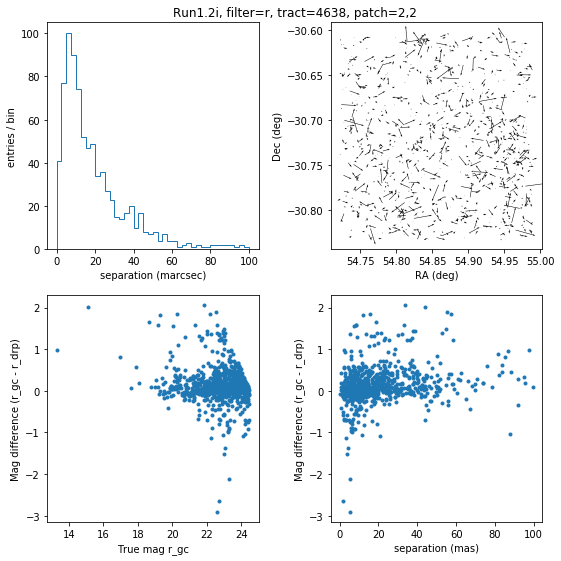

In [41]:
compare_differences(drp_obj_catalog, obj_matches)

Number of matches: 0


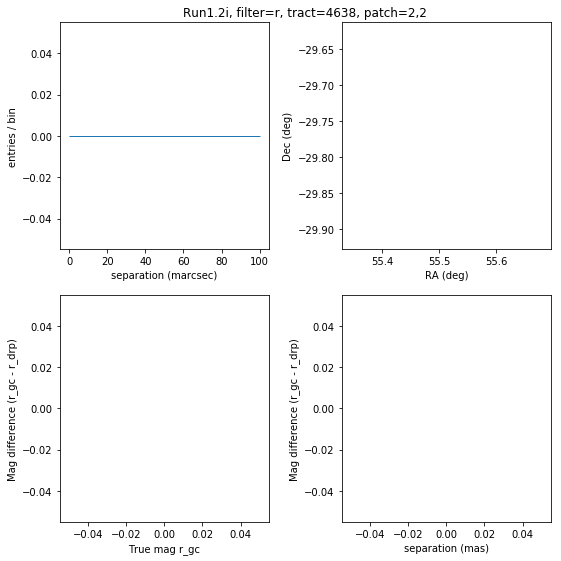

In [42]:
compare_differences(drp_src_catalog, src_matches)

### Going Further

The available columns in a `SourceCatalog` can be seen by printing the info from the schema that it carries around with it. The cells below show you what you have available. The drp_catalog and galaxy_catalog that we made to do the spatial matching only have positions and magnitudes in them - but the parent catalogs have many more quantities. 

In [ ]:
for item in drp_catalog.schema:
    print("{}:  {}".format(item.field.getName(), item.field.getDoc()))

In [ ]:
for item in galaxy_catalog.schema:
    print("{}:  {}".format(item.field.getName(), item.field.getDoc()))

In [ ]:
# All the DRP measurements:
for item in catalog.schema:
    print("{}:  {}".format(item.field.getName(), item.field.getDoc()))

In [ ]:
# All the protoDC2 parameters:
# help(gc)
gc.list_all_quantities()